# Modélisation pour la variable *SiteEnergyUse(kBtu)*

<a id="0"></a> <br>
# Table of Contents  

1. [Premières observations](#1)
    * [1.1 Chargement du jeu de données](#2)
    * [1.2 Préparation des données](#3)
2.[Cross validation des modèles sans optimisation](#4)
3.[Optimisation des modèles](#5)
4.[Comparaison des modèles](#6)
5.[Prédictions pour chaque modèle](#7)
6.[Sélection du modèle](#8)
7.[Impact de l'Energy Star Score](#9)
8.[Feature Importance](#10)

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fc
import importlib
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import time 

In [83]:
importlib.reload(fc)

<module 'functions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 4/à zip/functions.py'>

In [84]:
# Paramètres d'affichage
#pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# <a id="1"></a> 1. Premières observations
## <a id="2"></a> 1.1 Chargement du jeu de données

In [85]:
data = pd.read_csv('/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 4/data_cleaned.csv')

In [86]:
data_original = data.copy()

In [87]:
data.head()

,OSEBuildingID,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,SteamUseMost,NaturalGasUseMost,ElectricityUseMost,ParkingRatioGFA,MoreThan1Building
0,1,DOWNTOWN,12,88434,Hotel,88434.0,None,0.0,None,0.0,60.0,7226362.5,249.98,89,True,True,True,False,False,True,0.000000,False
1,2,DOWNTOWN,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8387933.0,295.86,20,True,False,True,False,True,False,0.145453,False
2,3,DOWNTOWN,41,956110,Hotel,756493.0,None,0.0,None,0.0,43.0,72587024.0,2089.28,47,True,True,True,False,False,True,0.205748,False
3,5,DOWNTOWN,10,61320,Hotel,61320.0,None,0.0,None,0.0,56.0,6794584.0,286.43,90,True,True,True,False,False,True,0.000000,False
4,8,DOWNTOWN,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,14172606.0,505.01,36,True,False,True,False,True,False,0.353115,False


In [88]:
data.shape

(1477, 22)

In [89]:
data.columns

Index(['OSEBuildingID', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'ElectricityUse', 'SteamUse', 'NaturalGasUse',
       'SteamUseMost', 'NaturalGasUseMost', 'ElectricityUseMost',
       'ParkingRatioGFA', 'MoreThan1Building'],
      dtype='object')

In [90]:
data.dtypes

OSEBuildingID                        int64
Neighborhood                        object
NumberofFloors                       int64
PropertyGFATotal                     int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
BuildingAge                          int64
ElectricityUse                        bool
SteamUse                              bool
NaturalGasUse                         bool
SteamUseMost                          bool
NaturalGasUseMost                     bool
ElectricityUseMost                    bool
ParkingRatioGFA                    float64
MoreThan1Building                     bool
dtype: object

In [91]:
X = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1)
y = data.copy()['SiteEnergyUse(kBtu)']

## <a id="3"></a> 1.2 Préparation des données

In [92]:
# 20% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [93]:
col_quanti = X.select_dtypes(['int32','float64']).columns

col_quali = X.select_dtypes(['category','object','bool']).columns

In [94]:
std_scale = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quanti),
    ('quali',ohe,col_quali)
])

In [95]:
X_train.shape

(1181, 18)

In [96]:
X_test.shape

(296, 18)

In [97]:
y_train_log = np.log(y_train)

On peut observer la différence entre la distribution de la target *SiteEnergyUse(kBtu)* et sa distribution après sa transformation.

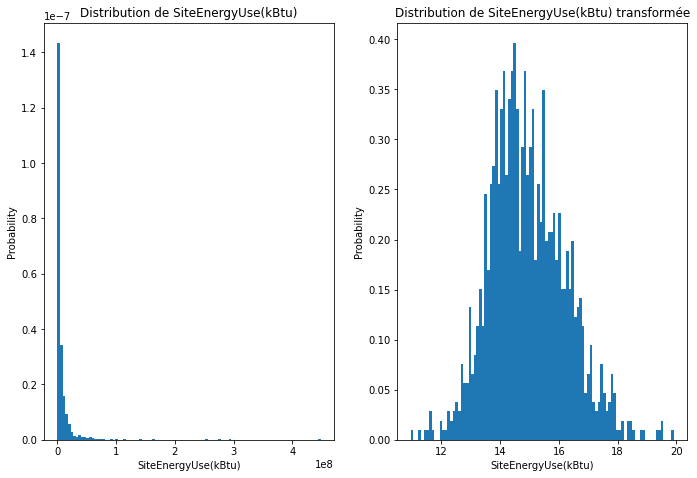

In [98]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,7))

ax0.hist(y_train, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("SiteEnergyUse(kBtu)")
ax0.set_title("Distribution de SiteEnergyUse(kBtu)")

ax1.hist(y_train_log, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("SiteEnergyUse(kBtu)")
ax1.set_title("Distribution de SiteEnergyUse(kBtu) transformée")

plt.tight_layout(pad=2)


# <a id="4"></a> 2. Cross validation des modèles sans optimisation

In [99]:
resultats_cv_y = fc.cross_valid(X_train,y_train,preprocessor)

/Users/oceaneyouyoutte/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.677e+16, tolerance: 5.899e+13
  model = cd_fast.enet_coordinate_descent(
/Users/oceaneyouyoutte/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+16, tolerance: 3.855e+13
  model = cd_fast.enet_coordinate_descent(
/Users/oceaneyouyoutte/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [100]:
resultats_cv_y

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME
dum,2.285266e+07,-1.930434e-02,8.974132e+06,6.459134e+06,0.020703,0.010414
lr,9.130438e+17,-2.031080e+21,9.253897e+16,2.510555e+06,0.019085,0.007858
ridge,1.604764e+07,4.663336e-01,5.798729e+06,2.504406e+06,0.012783,0.007268
lasso,1.747112e+07,2.658583e-01,6.046769e+06,2.386991e+06,0.126992,0.008265
ElasticNet,1.694051e+07,4.693654e-01,5.409339e+06,2.391078e+06,0.014273,0.007226
RandomForest,1.333716e+07,5.672663e-01,3.903943e+06,1.127353e+06,1.153621,0.021705
KNR,1.692918e+07,4.681191e-01,4.750653e+06,1.402289e+06,0.015241,0.016464
SVR,2.341639e+07,-6.500742e-02,6.985664e+06,1.852606e+06,0.096768,0.050429
XGBR,1.513878e+07,3.223075e-01,4.066936e+06,1.103096e+06,0.414805,0.012128


In [101]:
resultats_cv_y_log = fc.cross_valid(X_train,y_train_log,preprocessor)

In [102]:
resultats_cv_y_log

,RMSE,R2,MAE,MedAE,FIT_TIME,SCORE_TIME
dum,1.287039e+00,-2.470693e-03,1.026176e+00,0.875725,0.019441,0.010443
lr,1.665601e+10,-2.563512e+20,2.319685e+09,0.574233,0.017693,0.007270
ridge,8.286052e-01,5.822809e-01,6.496803e-01,0.553595,0.012601,0.007116
lasso,1.287039e+00,-2.470693e-03,1.026176e+00,0.875725,0.012372,0.007122
ElasticNet,1.175119e+00,1.645134e-01,9.500257e-01,0.821818,0.012943,0.045855
RandomForest,6.816806e-01,7.173551e-01,5.131139e-01,0.386688,0.969942,0.030146
KNR,8.441212e-01,5.691695e-01,6.479010e-01,0.517739,0.017252,0.018667
SVR,7.095940e-01,6.947184e-01,5.412912e-01,0.435238,0.097933,0.045648
XGBR,6.780001e-01,7.208610e-01,5.112961e-01,0.408970,0.408457,0.012517


De manière générale, on observe une amélioration des performances des différents modèles lorsque la target a été transformée en log. Nous continuerons donc avec cette configuration.


# <a id="5"></a> 3. Optimisation des modèles 

In [386]:
def grid_search_cv(model,params):
    
    grid = Pipeline([('preprocessor', preprocessor),('grid_search', GridSearchCV(
        TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp),
        param_grid=params,
        cv=5,
        scoring=('neg_root_mean_squared_error','r2','neg_mean_absolute_error','neg_median_absolute_error', 'neg_mean_squared_log_error'),
        return_train_score = True,
        refit='r2',
        n_jobs = -1
    ))])
    
    return grid

In [388]:
params_dum = {'regressor__strategy': ['mean', 'median']}
model_dum = grid_search_cv(DummyRegressor(),params_dum)
model_dum.fit(X_train,y_train)
model_dum_resultats = fc.metrics(model_dum)

Meilleurs paramètres {'regressor__strategy': 'mean'}
Meilleur score RMSLE : -1.6616783833163904
Meilleur score RMSE : -23335890.860349648
Meilleur score R2 : -0.056074234529824095
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__strategy,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
0,0.04266,0.035451,0.01602,0.015971,mean,{'regressor__strategy': 'mean'},-2.141142e+07,-3.675725e+07,-2.257274e+07,-2.526214e+07,-1.067591e+07,-2.333589e+07,8.347507e+06,1,-2.555818e+07,-2.074553e+07,-2.530840e+07,-2.465558e+07,-2.716651e+07,-2.468684e+07,2.136785e+06,-0.055834,-0.041943,-0.05791,-0.057202,-0.067483,-0.056074,0.00818,1,-0.045252,-0.054902,-0.045014,-0.043922,-0.047386,-0.047295,0.003966,-6.664798e+06,-9.115368e+06,-6.952664e+06,-7.654995e+06,-4.616081e+06,-7.000781e+06,1.462974e+06,2,-7.081419e+06,-6.467066e+06,-7.007361e+06,-6.835416e+06,-7.600851e+06,-6.998423e+06,368456.190598,-2.066560e+06,-2.049659e+06,-2.007454e+06,-2.247467e+06,-2.055491e+06,-2.085326e+06,83508.227913,2,-2.091060e+06,-2.069459e+06,-2.085342e+06,-2.060995e+06,-2.153307e+06,-2.092033e+06,32474.922538,-1.624885,-1.743731,-1.667596,-1.917845,-1.354335,-1.661678,0.183414,1,-1.66929,-1.639691,-1.658685,-1.596071,-1.737393,-1.660226,0.045993


In [390]:
params_lr =  {"regressor__fit_intercept": [True, False],
             "regressor__positive": [True, False]
             }

model_lr = grid_search_cv(LinearRegression(),params_lr)
model_lr.fit(X_train,y_train)
model_lr_resultats = fc.metrics(model_lr)

One or more of the test scores are non-finite: [            nan             nan -8.15140622e+08             nan]
One or more of the test scores are non-finite: [          nan           nan -5953.8320863           nan]
One or more of the test scores are non-finite: [               nan                nan -64808980.13878778
                nan]
One or more of the test scores are non-finite: [             nan              nan -1316816.8410897              nan]
One or more of the test scores are non-finite: [        nan         nan -1.74059425         nan]


Meilleurs paramètres {'regressor__fit_intercept': False, 'regressor__positive': True}
Meilleur score RMSLE : -1.7405942504601466
Meilleur score RMSE : -815140622.3143208
Meilleur score R2 : -5953.832086298666
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__positive,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
2,0.108345,0.046454,0.006613,0.002749,False,True,"{'regressor__fit_intercept': False, 'regressor...",-7.649981e+07,-7.020905e+07,-3.781347e+09,-6.618190e+07,-8.146578e+07,-8.151406e+08,1.483112e+09,1,-1.042572e+08,-1.067638e+08,-1.037981e+08,-1.088356e+08,-1.179921e+08,-1.083294e+08,5.161229e+06,-12.477998,-2.801404,-29686.466432,-6.255982,-61.158615,-5953.832086,11866.335995,1,-16.392945,-26.939004,-16.578075,-19.341322,-18.758104,-19.60189,3.848478,-9.440379e+06,-1.071403e+07,-2.848940e+08,-9.544698e+06,-9.451834e+06,-6.480898e+07,1.100435e+08,1,-9.748135e+06,-9.903188e+06,-9.593105e+06,-9.474159e+06,-1.111972e+07,-9.967662e+06,593873.827616,-1.215460e+06,-1.286550e+06,-1.376527e+06,-1.535530e+06,-1.170017e+06,-1.316817e+06,129723.073339,1,-1.072233e+06,-1.037050e+06,-1.008443e+06,-1.044291e+06,-1.115673e+06,-1.055538e+06,36280.102491,-1.270275,-2.514913,-3.007888,-0.900186,-1.00971,-1.740594,0.856421,1,-0.525391,-0.512705,-0.510158,-0.508774,-0.529686,-0.517343,0.008529


In [391]:
params_ridge =  {'regressor__alpha': np.arange(0, 2000, 100)}

model_ridge = grid_search_cv(Ridge(),params_ridge)
model_ridge.fit(X_train,y_train)
model_ridge_resultats = fc.metrics(model_ridge)

Meilleurs paramètres {'regressor__alpha': 1100}
Meilleur score RMSLE : -0.8160939881608822
Meilleur score RMSE : -16087560.034829866
Meilleur score R2 : 0.4600903508708615
Résultats des meilleurs paramètres :



One or more of the test scores are non-finite: [            nan -1.00119826e+08 -6.68533290e+07 -4.73177313e+07
 -3.50667488e+07 -2.71416095e+07 -2.20050864e+07 -1.87932724e+07
 -1.69920091e+07 -1.62192440e+07 -1.60875600e+07 -1.62859270e+07
 -1.66391766e+07 -1.70575052e+07 -1.74919394e+07 -1.79151758e+07
 -1.83131234e+07 -1.86797859e+07 -1.90138042e+07 -1.93162612e+07]
One or more of the test scores are non-finite: [            nan -4.38230399e+01 -1.78724868e+01 -7.79726984e+00
 -3.45979367e+00 -1.44815411e+00 -4.66092524e-01  2.70161482e-02
  2.74918671e-01  3.94817119e-01  4.46088365e-01  4.60090351e-01
  4.53924401e-01  4.37138813e-01  4.15146069e-01  3.91033102e-01
  3.66551884e-01  3.42676409e-01  3.19923008e-01  2.98537972e-01]
One or more of the test scores are non-finite: [               nan -12107159.63388662  -9496920.20539083
  -7936537.79947963  -6944650.48196045  -6327485.1451376
  -5917774.33797089  -5622698.12741708  -5416659.88633111
  -5357618.08141217  -5406512.5665

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
11,0.01578,0.005102,0.01361,0.008955,1100,{'regressor__alpha': 1100},-2.036015e+07,-2.329696e+07,-1.129040e+07,-1.990313e+07,-6.578990e+06,-1.628593e+07,6.293139e+06,3,-1.630814e+07,-1.546129e+07,-1.864368e+07,-1.641660e+07,-1.852643e+07,-1.707123e+07,1.280075e+06,0.0453,0.581441,0.735334,0.343763,0.594613,0.46009,0.242555,1,0.574431,0.414058,0.432905,0.537189,0.512895,0.494296,0.061342,-5.869180e+06,-6.963256e+06,-4.741058e+06,-6.318129e+06,-3.422238e+06,-5.462772e+06,1.251631e+06,4,-5.301889e+06,-5.032964e+06,-5.598350e+06,-5.170341e+06,-5.827898e+06,-5.386288e+06,289338.324316,-1.491992e+06,-1.469294e+06,-1.530798e+06,-1.613050e+06,-1.483766e+06,-1.517780e+06,51805.050412,11,-1.471699e+06,-1.471762e+06,-1.513087e+06,-1.521157e+06,-1.558283e+06,-1.507197e+06,32726.338708,-1.074119,-1.126189,-0.953228,-1.175728,-0.822473,-1.030347,0.12759,11,-1.008226,-0.996213,-1.043601,-0.99642,-1.062448,-1.021382,0.026869


In [392]:
params_lasso =  {'regressor__alpha': np.arange(0.0, 1.0, 0.001)}

model_lasso = grid_search_cv(Lasso(),params_lasso)
model_lasso.fit(X_train,y_train)
model_lasso_resultats = fc.metrics(model_lasso)

Meilleurs paramètres {'regressor__alpha': 0.41600000000000004}
Meilleur score RMSLE : -0.6795533062194326
Meilleur score RMSE : -20211378.187746543
Meilleur score R2 : 0.24622086849307628
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
416,0.007838,0.001994,0.003291,0.000175,0.416,{'regressor__alpha': 0.41600000000000004},-2.037849e+07,-3.550655e+07,-1.634525e+07,-2.226243e+07,-7.042254e+06,-2.030700e+07,9.235844e+06,45,-2.218881e+07,-1.749487e+07,-2.329304e+07,-2.256034e+07,-2.400489e+07,-2.190839e+07,2.293269e+06,0.04358,0.027757,0.445293,0.178962,0.535512,0.246221,0.20815,1,0.212177,0.249787,0.114792,0.125965,0.182216,0.176988,0.051063,-6.039823e+06,-8.592385e+06,-5.748071e+06,-6.884209e+06,-3.783478e+06,-6.209593e+06,1.565929e+06,103,-6.146436e+06,-5.567771e+06,-6.235995e+06,-6.064634e+06,-6.690063e+06,-6.140980e+06,359150.938436,-1.696997e+06,-1.804727e+06,-1.760289e+06,-1.995275e+06,-1.705887e+06,-1.792635e+06,108560.912182,417,-1.769823e+06,-1.767177e+06,-1.794941e+06,-1.780091e+06,-1.826151e+06,-1.787637e+06,21585.13719,-1.259045,-1.31703,-1.151977,-1.403581,-0.980323,-1.222391,0.146072,417,-1.186941,-1.206609,-1.234371,-1.204626,-1.250295,-1.216568,0.022689


In [393]:
params_elastic =  {'regressor__alpha': np.arange(0.0, 1.1, 0.001),
                   'regressor__l1_ratio': np.arange(0.0, 1.1, 0.1)
                  }

model_elastic = grid_search_cv(ElasticNet(),params_elastic)
model_elastic.fit(X_train,y_train)
model_elastic_resultats = fc.metrics(model_elastic)

Meilleurs paramètres {'regressor__alpha': 1.099, 'regressor__l1_ratio': 0.0}
Meilleur score RMSLE : -0.6794599663638481
Meilleur score RMSE : -16080752.392334476
Meilleur score R2 : 0.4546604093946994
Résultats des meilleurs paramètres :



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.042e+02, tolerance: 1.961e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
12089,0.19238,0.060968,0.002697,0.000821,1.099,0.0,"{'regressor__alpha': 1.099, 'regressor__l1_rat...",-2.056890e+07,-2.268816e+07,-1.059930e+07,-1.966291e+07,-7.170832e+06,-1.613802e+07,6.099997e+06,119,-1.600429e+07,-1.534430e+07,-1.848842e+07,-1.620124e+07,-1.837920e+07,-1.688349e+07,1.297733e+06,0.025623,0.603031,0.766743,0.359508,0.518396,0.45466,0.251634,1,0.590142,0.422892,0.44231,0.549252,0.520606,0.505041,0.063439,-5.912514e+06,-6.861011e+06,-4.590895e+06,-6.287874e+06,-3.487556e+06,-5.427970e+06,1.224232e+06,262,-5.254414e+06,-5.015032e+06,-5.595075e+06,-5.130605e+06,-5.772874e+06,-5.353600e+06,285759.925164,-1.477870e+06,-1.459162e+06,-1.512543e+06,-1.587011e+06,-1.467299e+06,-1.500777e+06,46801.692296,3671,-1.453981e+06,-1.455820e+06,-1.507601e+06,-1.515180e+06,-1.542108e+06,-1.494938e+06,34648.926047,-1.065727,-1.117908,-0.943491,-1.164802,-0.815814,-1.021548,0.126632,3876,-0.999144,-0.987346,-1.034281,-0.987773,-1.052959,-1.012301,0.026584


In [394]:
params_knr =  {"regressor__n_neighbors": list(range(2, 21)), 
               "regressor__weights": ['uniform', 'distance'], 
               "regressor__leaf_size": list(range(0, 35)),
               "regressor__p": [1,2]
              }

model_knr = grid_search_cv(KNeighborsRegressor(),params_knr)
model_knr.fit(X_train,y_train)
model_knr_resultats = fc.metrics(model_knr)

Meilleurs paramètres {'regressor__leaf_size': 0, 'regressor__n_neighbors': 2, 'regressor__p': 2, 'regressor__weights': 'distance'}
Meilleur score RMSLE : -0.6929531374791403
Meilleur score RMSE : -15463966.73329495
Meilleur score R2 : 0.5356406012753407
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__leaf_size,param_regressor__n_neighbors,param_regressor__p,param_regressor__weights,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
3,0.003498,0.000258,0.011669,0.000984,0,2,2,distance,"{'regressor__leaf_size': 0, 'regressor__n_neig...",-1.992412e+07,-3.091761e+07,-1.029574e+07,-1.102815e+07,-5.154206e+06,-1.546397e+07,9.070681e+06,1,-0.111843,-9900.411786,-9900.411787,-9900.411787,-9900.411787,-7920.351798,3960.119977,0.085754,0.262826,0.779912,0.798524,0.751186,0.535641,0.300687,1,1.0,1.0,1.0,1.0,1.0,1.0,7.853528e-08,-5.389404e+06,-6.850846e+06,-4.111825e+06,-4.325600e+06,-2.862251e+06,-4.707985e+06,1.338996e+06,316,-0.01346,-454.372018,-454.37953,-454.381171,-454.376624,-363.504561,181.74555,-1.231906e+06,-1.311468e+06,-1.303638e+06,-1.303570e+06,-1.269810e+06,-1.284078e+06,29793.432724,2486,-1.164153e-09,-1.164153e-09,-1.164153e-09,-1.164153e-09,-1.164153e-09,-1.164153e-09,0.0,-0.953657,-0.932138,-0.753568,-0.865975,-0.712807,-0.843629,0.095566,2556,-3.816849e-16,-0.000042,-0.000042,-0.000042,-0.000042,-0.000034,0.000017


In [395]:
params_svr =  {'regressor__kernel': ['linear','poly', 'rbf', 'sigmoid'],
               'regressor__degree': [1,2,3,5],
               'regressor__gamma' : [1e-8, 1e-5, 1e-3, 1e-2, 1e-1],
               'regressor__C': [0.01, 0.1, 1, 10],
               'regressor__epsilon' : [0.001, 0.01, 0.1, 0.5, 1]
                  }

model_svr = grid_search_cv(SVR(),params_svr)
model_svr.fit(X_train,y_train)
model_svr_resultats = fc.metrics(model_svr)

One or more of the test scores are non-finite: [-3.60629568e+08 -2.34162641e+07 -2.34162640e+07 ... -1.77998233e+09
 -1.92252661e+07 -1.01127531e+50]
invalid value encountered in subtract
One or more of the test scores are non-finite: [-5.87861539e+02 -6.50019747e-02 -6.50019571e-02 ... -1.88660862e+04
  3.21068608e-01 -7.86721589e+85]
overflow encountered in square


Meilleurs paramètres {'regressor__C': 10, 'regressor__degree': 1, 'regressor__epsilon': 0.001, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}
Meilleur score RMSLE : -0.4898113414503477
Meilleur score RMSE : -15720460.584789336
Meilleur score R2 : 0.5046464400051958
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__C,param_regressor__degree,param_regressor__epsilon,param_regressor__gamma,param_regressor__kernel,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
1218,0.278032,0.007099,0.085428,0.00201,10,1,0.001,0.1,rbf,"{'regressor__C': 10, 'regressor__degree': 1, '...",-1.731386e+07,-3.232140e+07,-1.306474e+07,-1.501599e+07,-5.195596e+06,-1.658232e+07,8.862709e+06,17,-1.719651e+06,-1.794774e+06,-1.796496e+06,-1.926050e+06,-1.826837e+06,-1.812762e+06,66768.542667,0.309613,0.194365,0.64561,0.62647,0.747174,0.504646,0.213468,1,0.995268,0.992104,0.994734,0.99363,0.995264,0.9942,0.001206,-3.948462e+06,-6.842893e+06,-4.289104e+06,-4.502991e+06,-2.419470e+06,-4.400584e+06,1.422464e+06,37,-480178.966639,-438089.540004,-517220.718538,-530710.643355,-542609.469001,-501761.867507,38119.604262,-1.086858e+06,-1.274977e+06,-1.178207e+06,-1.198472e+06,-947926.341729,-1.137288e+06,112050.924812,81,-11163.745834,-10135.902732,-10651.090414,-12052.05582,-12394.909043,-11279.540769,843.456243,-0.401863,-0.6251,-0.523762,-0.532674,-0.403983,-0.497476,0.084971,13,-0.116794,-0.106457,-0.112819,-0.107748,-0.123683,-0.1135,0.006288


In [396]:
params_rf =  {'regressor__n_estimators' : [100, 200, 500, 800, 1000, 2000],
              'regressor__max_depth': [1, 2, 3, 4, 5, None],
                  }

model_rf = grid_search_cv(RandomForestRegressor(),params_rf)
model_rf.fit(X_train,y_train)
model_rf_resultats = fc.metrics(model_rf)

Meilleurs paramètres {'regressor__max_depth': None, 'regressor__n_estimators': 200}
Meilleur score RMSLE : -0.46826162887482214
Meilleur score RMSE : -14158024.48176243
Meilleur score R2 : 0.6169036053601038
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
31,2.411725,0.031682,0.04022,0.002471,None,200,"{'regressor__max_depth': None, 'regressor__n_e...",-1.834934e+07,-2.794112e+07,-7.920097e+06,-1.271381e+07,-3.865755e+06,-1.415802e+07,8.419846e+06,1,-8.798815e+06,-7.352647e+06,-1.089576e+07,-1.074205e+07,-1.076045e+07,-9.709945e+06,1.411522e+06,0.224565,0.397932,0.869761,0.732225,0.860035,0.616904,0.260087,1,0.876118,0.867489,0.80631,0.801842,0.835677,0.837487,0.030458,-4.037452e+06,-5.878153e+06,-3.145835e+06,-3.705295e+06,-2.130901e+06,-3.779527e+06,1.232542e+06,1,-1.664425e+06,-1.438997e+06,-1.871903e+06,-1.869414e+06,-1.914055e+06,-1.751759e+06,178921.340634,-895463.457416,-1.180842e+06,-958785.400667,-875374.388343,-913527.519075,-964798.640792,111484.415116,6,-335793.301038,-299053.868606,-327604.195577,-338167.458004,-331515.864473,-326426.93754,14157.235624,-0.454117,-0.568964,-0.43404,-0.497084,-0.388467,-0.468534,0.061172,3,-0.065848,-0.059173,-0.063789,-0.064095,-0.067385,-0.064058,0.002765


In [397]:
model_rf.score(X_train, y_train)

0.8490970081492162

In [398]:
params_xgb = {'regressor__gamma': [0,0.001,0.01,0.1,0.5,1],
              'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
              'regressor__max_depth': [2,4,6],
              'regressor__n_estimators': [100, 200, 300, 400, 500],
             }


model_xgb = grid_search_cv(XGBRegressor(),params_xgb)
model_xgb.fit(X_train,y_train)
model_xgb_resultats = fc.metrics(model_xgb)

Meilleurs paramètres {'regressor__gamma': 0.001, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 4, 'regressor__n_estimators': 400}
Meilleur score RMSLE : -0.4069237280272636
Meilleur score RMSE : -10421324.537156763
Meilleur score R2 : 0.7958977546636725
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
128,4.453809,0.040689,0.007874,0.0001,0.001,0.2,4,400,"{'regressor__gamma': 0.001, 'regressor__learni...",-7.704454e+06,-2.659879e+07,-7.443497e+06,-6.245603e+06,-4.114277e+06,-1.042132e+07,8.187488e+06,1,-2.257534e+06,-1.715946e+06,-1.716655e+06,-2.054474e+06,-2.151800e+06,-1.979282e+06,224124.762611,0.863294,0.454391,0.884964,0.93538,0.84146,0.795898,0.17357,1,0.991845,0.992783,0.995192,0.992752,0.993429,0.9932,0.001116,-3.008551e+06,-5.218389e+06,-3.242831e+06,-2.711236e+06,-2.219573e+06,-3.280116e+06,1.027659e+06,3,-825320.130869,-695773.075755,-749816.596479,-832797.544879,-894693.746644,-799680.218925,69375.511613,-1093719.75,-1.140687e+06,-1023403.375,-1.003893e+06,-980855.9375,-1.048512e+06,59562.682361,262,-289730.98435,-267872.25,-274289.25,-330758.75,-309712.25,-294472.69687,23179.131866,-0.384338,-0.526365,-0.506487,-0.477009,-0.399927,-0.458825,0.056888,239,-0.051174,-0.043917,-0.045634,-0.053041,-0.055308,-0.049815,0.004352


In [399]:
model_xgb.score(X_train, y_train)

0.9912262468566737

# <a id="6"></a> 4. Comparaison des modèles 

Nous allons désormais comparer les résultats des différents modèles afin de sélectionner le plus pertinent pour notre étude. 

In [401]:
metrics = ['mean_test_neg_mean_squared_log_error','mean_test_r2','mean_test_neg_root_mean_squared_error',
           'mean_test_neg_mean_absolute_error','mean_test_neg_median_absolute_error','params','mean_fit_time',
          'mean_score_time']


compare_metrics = pd.concat([model_dum_resultats.loc[model_dum_resultats['params']==model_dum['grid_search'].best_params_][metrics],
                             model_lr_resultats.loc[model_lr_resultats['params']==model_lr['grid_search'].best_params_][metrics],
                             model_ridge_resultats.loc[model_ridge_resultats['params']==model_ridge['grid_search'].best_params_][metrics],
                             model_lasso_resultats.loc[model_lasso_resultats['params']==model_lasso['grid_search'].best_params_][metrics],
                             model_elastic_resultats.loc[model_elastic_resultats['params']==model_elastic['grid_search'].best_params_][metrics],
                             model_knr_resultats.loc[model_knr_resultats['params']==model_knr['grid_search'].best_params_][metrics],
                             model_svr_resultats.loc[model_svr_resultats['params']==model_svr['grid_search'].best_params_][metrics],
                             model_rf_resultats.loc[model_rf_resultats['params']==model_rf['grid_search'].best_params_][metrics],
                             model_xgb_resultats.loc[model_xgb_resultats['params']==model_xgb['grid_search'].best_params_][metrics]
                            ])

compare_metrics.reset_index(drop=True,inplace=True)
compare_metrics = compare_metrics.rename(index = {0:'dum',1:'lr',2:'ridge',3:'lasso',4:'ElasticNet',5:'KNR', 
                                6:'SVR',7:'RandomForest',8:'XGBR'})

In [402]:
compare_metrics

,mean_test_neg_mean_squared_log_error,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_absolute_error,mean_test_neg_median_absolute_error,params,mean_fit_time,mean_score_time
dum,-1.661678,-0.056074,-2.333589e+07,-7.000781e+06,-2.085326e+06,{'regressor__strategy': 'mean'},0.042660,0.016020
lr,-1.740594,-5953.832086,-8.151406e+08,-6.480898e+07,-1.316817e+06,"{'regressor__fit_intercept': False, 'regressor...",0.108345,0.006613
ridge,-1.030347,0.460090,-1.628593e+07,-5.462772e+06,-1.517780e+06,{'regressor__alpha': 1100},0.015780,0.013610
lasso,-1.222391,0.246221,-2.030700e+07,-6.209593e+06,-1.792635e+06,{'regressor__alpha': 0.41600000000000004},0.007838,0.003291
ElasticNet,-1.021548,0.454660,-1.613802e+07,-5.427970e+06,-1.500777e+06,"{'regressor__alpha': 1.099, 'regressor__l1_rat...",0.192380,0.002697
KNR,-0.843629,0.535641,-1.546397e+07,-4.707985e+06,-1.284078e+06,"{'regressor__leaf_size': 0, 'regressor__n_neig...",0.003498,0.011669
SVR,-0.497476,0.504646,-1.658232e+07,-4.400584e+06,-1.137288e+06,"{'regressor__C': 10, 'regressor__degree': 1, '...",0.278032,0.085428
RandomForest,-0.468534,0.616904,-1.415802e+07,-3.779527e+06,-9.647986e+05,"{'regressor__max_depth': None, 'regressor__n_e...",2.411725,0.040220
XGBR,-0.458825,0.795898,-1.042132e+07,-3.280116e+06,-1.048512e+06,"{'regressor__gamma': 0.001, 'regressor__learni...",4.453809,0.007874


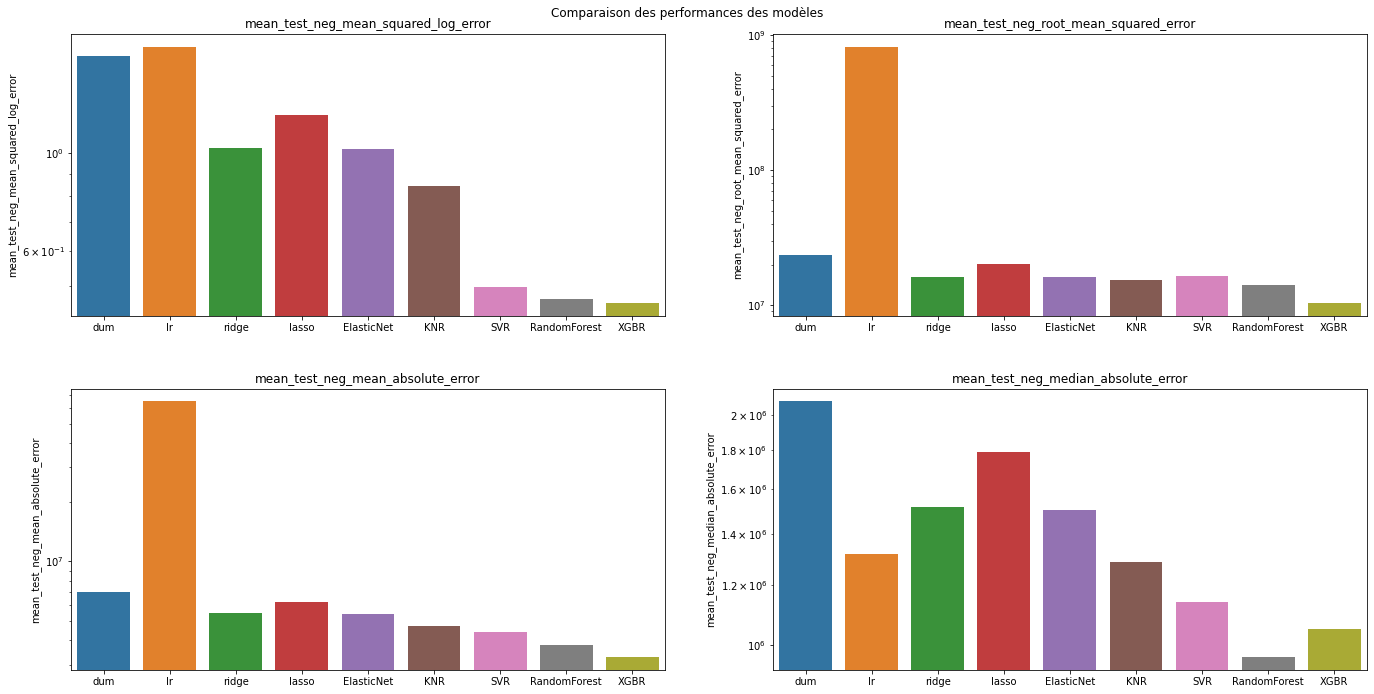

In [404]:
fc.bar_plot_compare(compare_metrics, compare_metrics.columns.drop(['params','mean_test_r2','mean_fit_time','mean_score_time']),True)

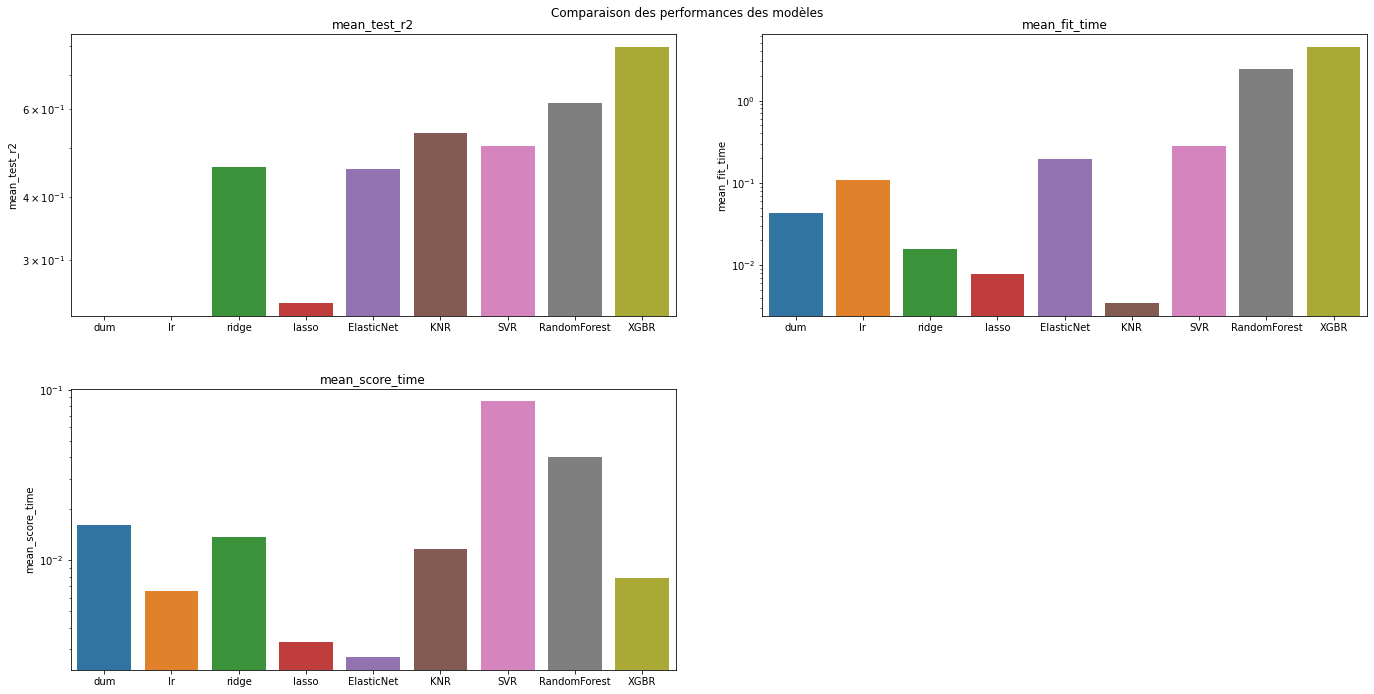

In [405]:
fc.bar_plot_compare(compare_metrics,['mean_test_r2','mean_fit_time','mean_score_time'],False)

# <a id="7"></a> 5. Prédictions pour chaque modèle

In [408]:
start_time = time.time()

#model_dum
y_pred_dum = model_dum.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.0099 s.


In [409]:
res_test_dum = fc.metrics_pred(y_test, y_pred_dum)
res_test_dum

,RMSLE,R2
0,1.874609,-0.113293


In [410]:
start_time = time.time()
y_pred_lr = model_lr.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.013 s.


In [411]:
res_test_lr = fc.metrics_pred(y_test, y_pred_lr)
res_test_lr

,RMSLE,R2
0,2.659094,-13.871825


In [412]:
start_time = time.time()
y_pred_ridge = model_ridge.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.013 s.


In [413]:
res_test_ridge = fc.metrics_pred(y_test, y_pred_ridge)
res_test_ridge

,RMSLE,R2
0,1.211187,-0.19575


In [414]:
start_time = time.time()
y_pred_lasso = model_lasso.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.012 s.


In [415]:
res_test_lasso = fc.metrics_pred(y_test, y_pred_lasso)
res_test_lasso

,RMSLE,R2
0,1.419196,0.10962


In [416]:
start_time = time.time()
y_pred_elastic = model_elastic.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.011 s.


In [417]:
res_test_elastic = fc.metrics_pred(y_test, y_pred_elastic)
res_test_elastic

,RMSLE,R2
0,1.239635,-0.045314


In [418]:
start_time = time.time()
y_pred_knr = model_knr.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.038 s.


In [419]:
res_test_knr = fc.metrics_pred(y_test, y_pred_knr)
res_test_knr

,RMSLE,R2
0,0.801308,0.39378


In [420]:
start_time = time.time()
y_pred_svr = model_svr.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.14 s.


In [421]:
res_test_svr = fc.metrics_pred(y_test, y_pred_svr)
res_test_svr

,RMSLE,R2
0,0.484281,0.605659


In [422]:
start_time = time.time()
y_pred_rf = model_rf.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.05 s.


In [423]:
res_test_rf = fc.metrics_pred(y_test, y_pred_rf)
res_test_rf

,RMSLE,R2
0,0.559049,0.688671


In [424]:
start_time = time.time()
y_pred_xgb = model_xgb.predict(X_test)

print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.015 s.


In [425]:
res_test_xgb = fc.metrics_pred(y_test, y_pred_xgb)
res_test_xgb

,RMSLE,R2
0,0.496152,0.635405


# <a id="8"></a> 6. Sélection du modèle

On choisit donc Random Forest Regressor qui offre un test score supérieur aux autres modèles. 

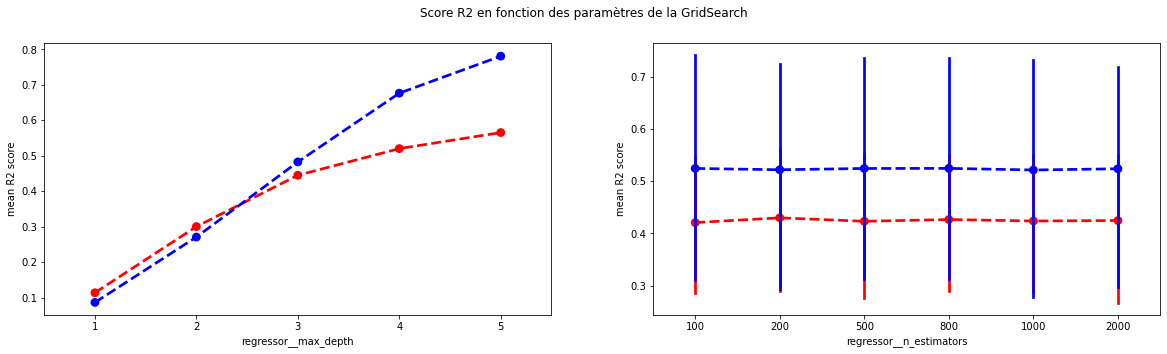

In [582]:
result = pd.DataFrame(model_rf['grid_search'].cv_results_)

params_names = list(model_rf['grid_search'].best_params_.keys())

fig, ax = plt.subplots(1,len(params_names),figsize=(20,5))

for i, param in enumerate(params_names) :

    sns.pointplot(x=result['param_' +param], y = 'mean_test_r2', data=result,
                  #errorbar=result['std_test_r2'], 
                  linestyles = '--', markers = 'o', color = 'red', labels= 'test', ax=ax[i])
    sns.pointplot(x='param_' +param, y='mean_train_r2', data=result, 
                  #errorbar=result['std_train_r2'], 
                  linestyles = '--', markers = 'o', color = 'blue', labels = 'train', ax=ax[i])
    ax[i].set_xlabel(param)
    ax[i].set_ylabel('mean R2 score')
  
    fig.suptitle('Score R2 en fonction des paramètres de la GridSearch')

plt.show()

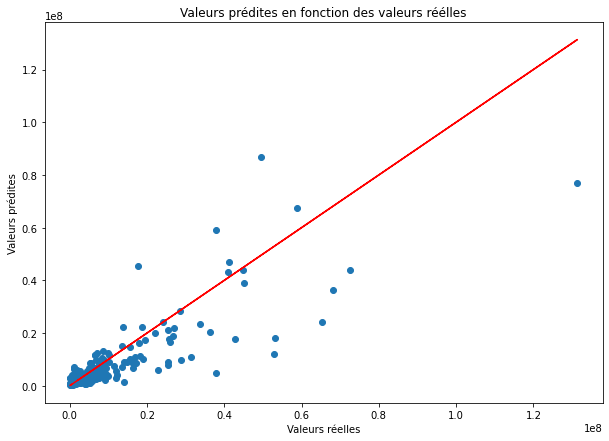

In [462]:
fc.plot_predict(y_test, y_pred_rf)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


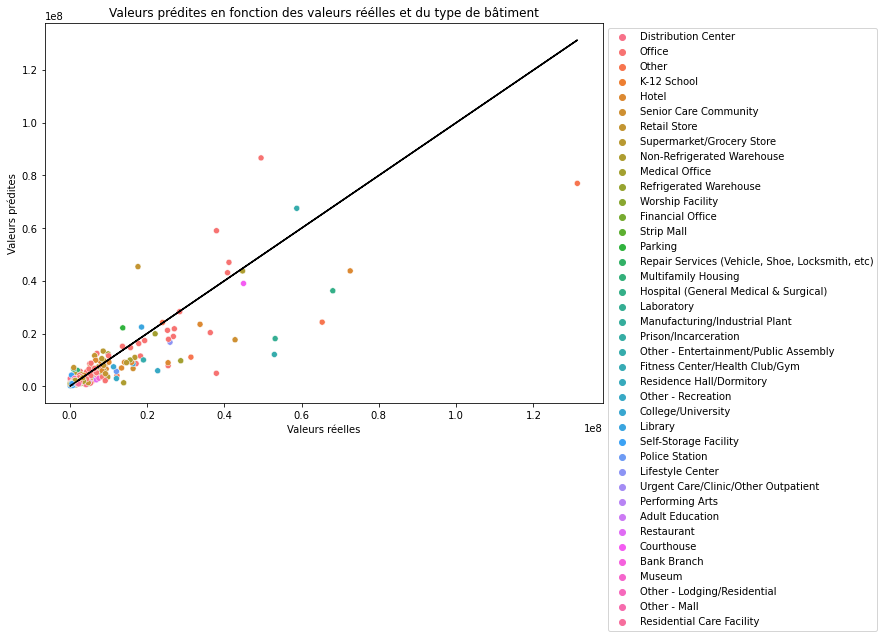

In [465]:
fc.plot_pred_class(y_test, y_pred_rf,'LargestPropertyUseType')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


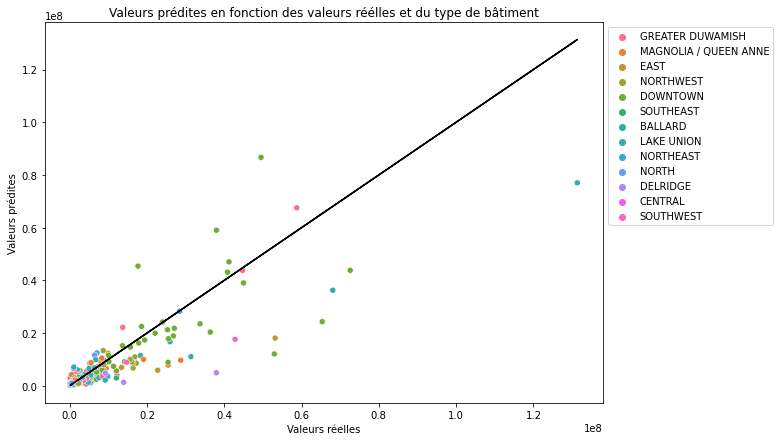

In [466]:
fc.plot_pred_class(y_test, y_pred_rf,'Neighborhood')

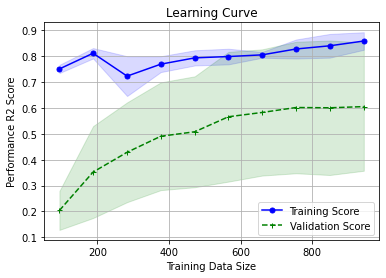

In [47]:
mod_pip_rf = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth = None, 
                                                                                      n_estimators= 200), 
                                                      func=np.log, inverse_func=np.exp))])


fc.plot_learning_curve(mod_pip_rf, X_train, y_train)

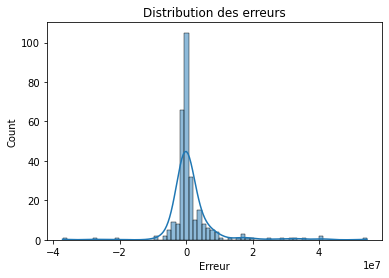

In [469]:
fc.plot_error(y_test, y_pred_rf)

# <a id="9"></a> 7. Impact de l'Energy Star Score

Nous allons désormais tester l'impact de la variable Energy Star Score sur les performances du modèle.

Dans un premier temps nous allons entraîner le modèle seulement sur les lignes complétées de Energy Star Score.

In [470]:
X_ESS = data.copy().drop(['OSEBuildingID','SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
y_ESS = data.copy()['SiteEnergyUse(kBtu)']

In [535]:
col_quant = X_ESS.select_dtypes(['int32','float64']).columns

col_qual = X_ESS.select_dtypes(['category','object','bool']).columns

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quant),
    ('quali',ohe,col_qual)
])

In [536]:
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state = 0)

In [537]:
X_train_ESS.shape

(1181, 19)

In [538]:
X_train_ESS = X_train_ESS[X_train_ESS['ENERGYSTARScore'].isna()==False]
y_train_ESS = y_train_ESS[y_train_ESS.index.isin(list(X_train_ESS.index))]
X_test_ESS = X_test_ESS[X_test_ESS['ENERGYSTARScore'].isna()==False]
y_test_ESS = y_test_ESS[y_test_ESS.index.isin(list(X_test_ESS.index))]

In [540]:
params_rf =  {'regressor__n_estimators' : [100, 200, 500, 800, 1000, 2000],
              'regressor__max_depth': [1, 2, 3, 4, 5, None],
                  }

mod_rf_ESS = grid_search_cv(RandomForestRegressor(),params_rf)
mod_rf_ESS.fit(X_train_ESS,y_train_ESS)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('quanti', StandardScaler(),
                                                  Index(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'ParkingRatioGFA'],
      dtype='object')),
                                                 ('quali',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Neighborhood', 'LargestPropertyUseT...
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor()),
                              n_jobs=-1,
                              param_grid={'regressor__max_depth': [1, 2, 3, 4,
                                                                   5, None],
                                          'regressor__n_estimators': [100, 200,
                                                                      500, 800,
                                                                      1000,
                                                                      2000]},
                              refit='r2', return_train_score=True,
                              scoring=('neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_error',
                                       'neg_median_absolute_error',
                                       'neg_mean_squared_log_error')))])

In [541]:
mod_rf_ESS_resultats = fc.metrics(mod_rf_ESS)

Meilleurs paramètres {'regressor__max_depth': None, 'regressor__n_estimators': 2000}
Meilleur score RMSLE : -0.39827988489251626
Meilleur score RMSE : -14549461.497680044
Meilleur score R2 : 0.5965924279959225
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
35,24.163494,3.700405,0.307354,0.079228,None,2000,"{'regressor__max_depth': None, 'regressor__n_e...",-1.881961e+07,-2.777615e+07,-1.010537e+07,-1.193316e+07,-4.113022e+06,-1.454946e+07,8.107943e+06,1,-8.423663e+06,-7.497456e+06,-1.073790e+07,-1.055424e+07,-1.050491e+07,-9.543634e+06,1.327616e+06,0.184309,0.40502,0.787976,0.764099,0.841557,0.596592,0.257438,1,0.886456,0.862218,0.811882,0.80871,0.843388,0.842531,0.029668,-3.888059e+06,-5.402149e+06,-3.106092e+06,-3.553923e+06,-2.042176e+06,-3.598480e+06,1.095773e+06,1,-1.550018e+06,-1.386056e+06,-1.767725e+06,-1.750118e+06,-1.829203e+06,-1.656624e+06,164584.145728,-760096.120487,-949811.353845,-896075.370063,-796247.629018,-817663.697322,-843978.834147,69168.830119,4,-284295.785306,-252196.293595,-284284.203215,-286272.180943,-293998.887835,-280209.470179,14456.444819,-0.398807,-0.446445,-0.362586,-0.440545,-0.34303,-0.398283,0.041069,2,-0.054636,-0.051845,-0.054187,-0.053815,-0.05567,-0.054031,0.001257


In [542]:
mod_rf_ESS.score(X_train_ESS,y_train_ESS)

0.8441921724101078

In [543]:
start_time = time.time()
y_pred_rf_ESS = mod_rf_ESS.predict(X_test_ESS)
print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.39 s.


In [544]:
res_test_rf_ESS = fc.metrics_pred(y_test_ESS, y_pred_rf_ESS)
res_test_rf_ESS

,RMSLE,R2
0,0.411317,0.720652


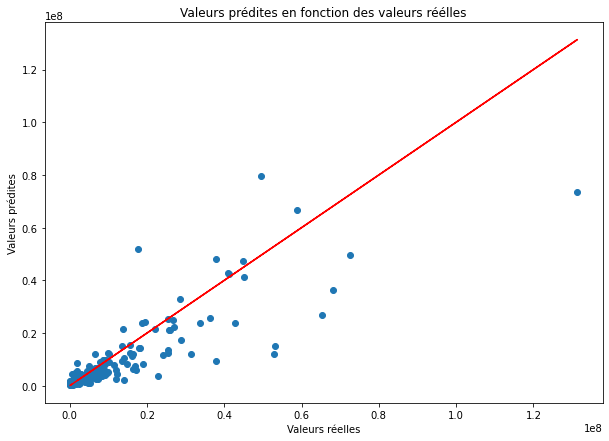

In [545]:
fc.plot_predict(y_test_ESS, y_pred_rf_ESS)

Nous allons désormais tester la variable *ENERGYSTARScore* en la complétant à l'aide d'un knn.

In [546]:
col_quanti = X_ESS.select_dtypes(['int32','float64']).columns

In [547]:
X_ESS[col_quanti] = fc.knn_imputer(X_ESS[col_quanti])

In [548]:
X_train_ESS_k, X_test_ESS_k, y_train_ESS_k, y_test_ESS_k = train_test_split(X_ESS, y_ESS, test_size=0.2, random_state = 0)

In [549]:
params_rf =  {'regressor__n_estimators' : [100, 200, 500, 800, 1000, 2000],
              'regressor__max_depth': [1, 2, 3, 4, 5, None],
                  }

mod_rf_ESSk = grid_search_cv(RandomForestRegressor(),params_rf)
mod_rf_ESSk.fit(X_train_ESS_k,y_train_ESS_k)
mod_rf_ESSk_resultats = fc.metrics(mod_rf_ESSk)

Meilleurs paramètres {'regressor__max_depth': None, 'regressor__n_estimators': 500}
Meilleur score RMSLE : -0.3962859239506657
Meilleur score RMSE : -14472346.84759659
Meilleur score R2 : 0.599496822494441
Résultats des meilleurs paramètres :



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_median_absolute_error,split1_test_neg_median_absolute_error,split2_test_neg_median_absolute_error,split3_test_neg_median_absolute_error,split4_test_neg_median_absolute_error,mean_test_neg_median_absolute_error,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_train_neg_median_absolute_error,split1_train_neg_median_absolute_error,split2_train_neg_median_absolute_error,split3_train_neg_median_absolute_error,split4_train_neg_median_absolute_error,mean_train_neg_median_absolute_error,std_train_neg_median_absolute_error,split0_test_neg_mean_squared_log_error,split1_test_neg_mean_squared_log_error,split2_test_neg_mean_squared_log_error,split3_test_neg_mean_squared_log_error,split4_test_neg_mean_squared_log_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error,split0_train_neg_mean_squared_log_error,split1_train_neg_mean_squared_log_error,split2_train_neg_mean_squared_log_error,split3_train_neg_mean_squared_log_error,split4_train_neg_mean_squared_log_error,mean_train_neg_mean_squared_log_error,std_train_neg_mean_squared_log_error
32,6.631968,0.08693,0.105186,0.008056,None,500,"{'regressor__max_depth': None, 'regressor__n_e...",-1.880509e+07,-2.759591e+07,-1.015205e+07,-1.165015e+07,-4.158526e+06,-1.447235e+07,8.049912e+06,1,-8.161015e+06,-7.495546e+06,-1.086621e+07,-1.086980e+07,-1.074233e+07,-9.626979e+06,1.484342e+06,0.185566,0.412717,0.786013,0.775156,0.838032,0.599497,0.256425,1,0.893427,0.862289,0.807359,0.797101,0.836229,0.839281,0.035408,-3.871090e+06,-5.381284e+06,-3.135483e+06,-3.511488e+06,-2.042534e+06,-3.588376e+06,1.085827e+06,1,-1.573487e+06,-1.385791e+06,-1.761821e+06,-1.771346e+06,-1.840342e+06,-1.666557e+06,165981.22668,-770385.605286,-942989.688286,-885349.843606,-810312.124125,-807129.628977,-843233.378056,62320.471366,4,-284172.510949,-245030.135993,-277165.919587,-303563.13734,-289933.313112,-279973.003396,19504.982721,-0.400405,-0.448066,-0.363892,-0.434643,-0.340827,-0.397567,0.04071,2,-0.056491,-0.052141,-0.054393,-0.054078,-0.056252,-0.054671,0.00159


In [550]:
start_time = time.time()
y_pred_rf_ESSk = mod_rf_ESSk.predict(X_test_ESS_k)
print("Temps d'exécution : {:.2} s.".format((time.time() - start_time)))

Temps d'exécution : 0.089 s.


In [551]:
res_test_rf_ESS_k = fc.metrics_pred(y_test_ESS_k, y_pred_rf_ESSk)
res_test_rf_ESS_k

,RMSLE,R2
0,0.405252,0.727552


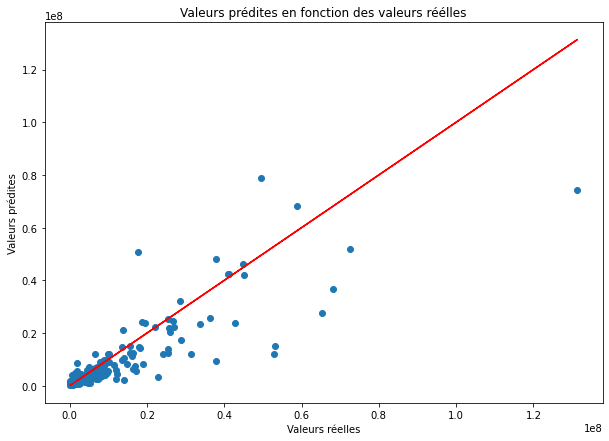

In [552]:
fc.plot_predict(y_test_ESS_k, y_pred_rf_ESSk)

In [553]:
df_comparaison = pd.concat([res_test_rf, res_test_rf_ESS,res_test_rf_ESS_k], axis = 0, 
                           keys=['Sans ESS', 'Avec ESS','Avec ESS imputée'])

df_comparaison

,,RMSLE,R2
Sans ESS,0,0.559049,0.688671
Avec ESS,0,0.411317,0.720652
Avec ESS imputée,0,0.405252,0.727552


L'*EnergyStarScore* qu'elle soit imputée ou non, offre de meilleures performances que le modèle de base. La variable imputée à l'aide d'un knn imputer offre des performances légèrement supérieures. 

En sachant que la variable est fastidieuse à calculer, il nous faudrait un avis métier pour savoir si le gain de performances obtenu est suffisamment conséquent pour l'intégrer au modèle ou si il n'est pas suffisant.

Ici, nous continuerons l'étude avec le modèle intégrant l'*EnergyStarScore* imputée.

# <a id="10"></a> 8. Feature importance 

In [554]:
mod_rf = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth= None, 
                                                                                      n_estimators= 500), 
                                                      func=np.log, inverse_func=np.exp))])


mod_rf.fit(X_train_ESS_k,y_train_ESS_k)
print(mod_rf.score(X_train_ESS_k,y_train_ESS_k))
print(mod_rf.score(X_test_ESS_k,y_test_ESS_k))

0.84347710283928
0.7261161222122984


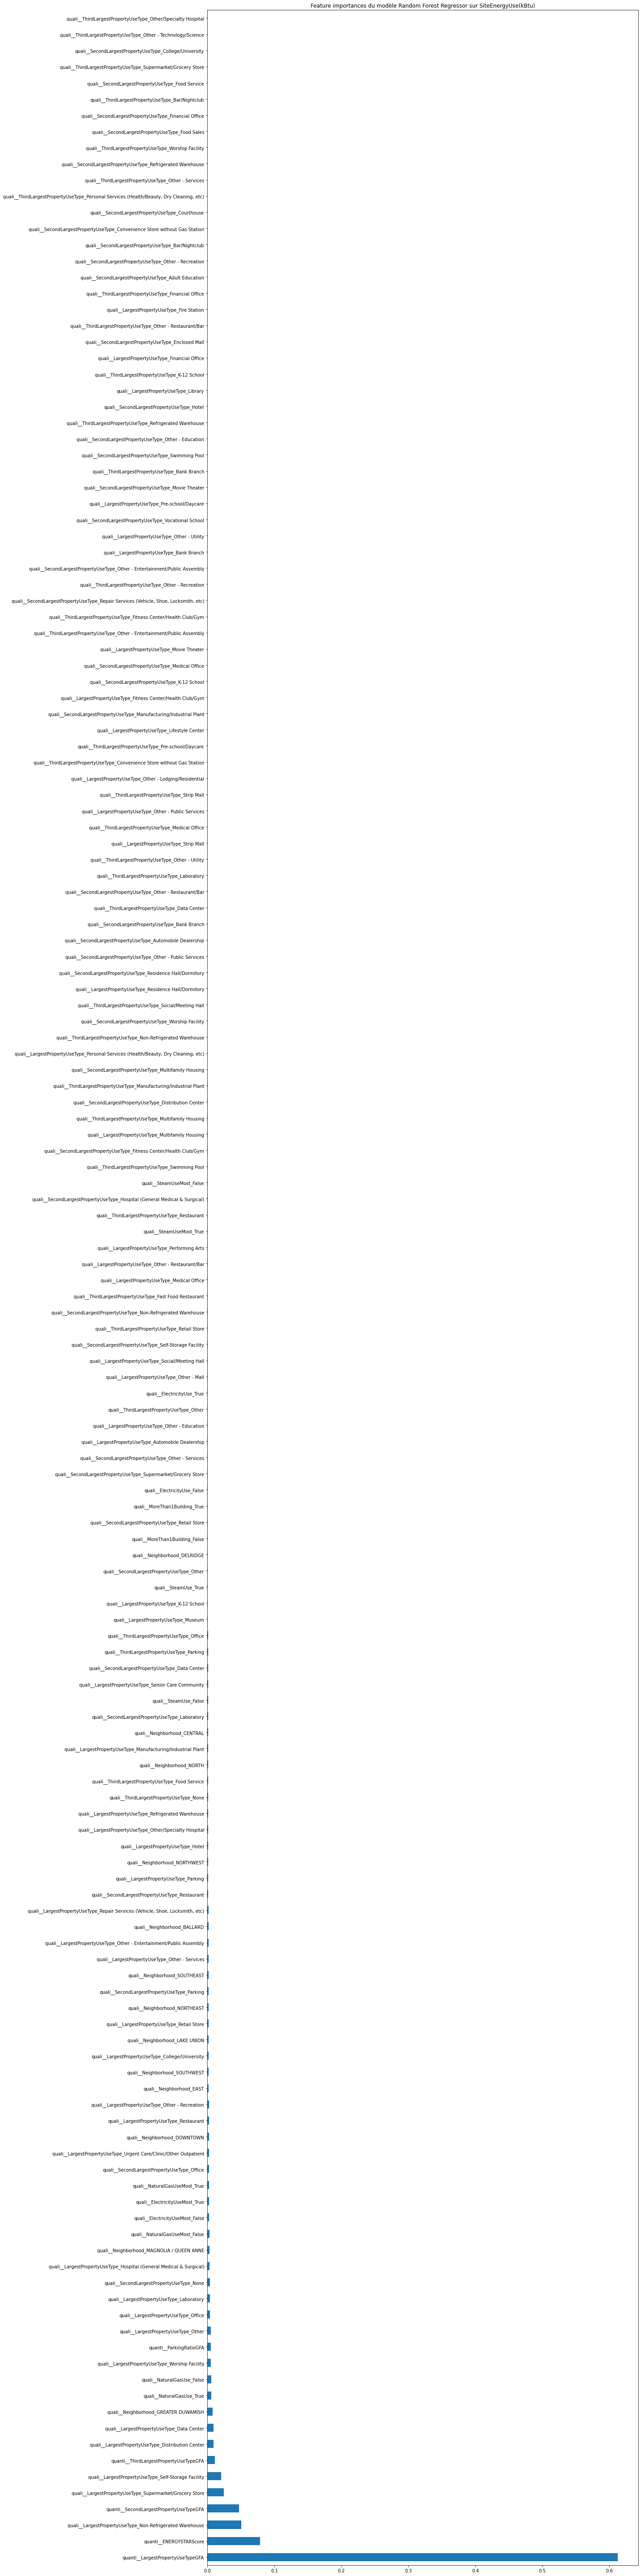

In [557]:
features_importance = mod_rf['model'].regressor_.feature_importances_
name_features = mod_rf['preprocessor'].get_feature_names_out()
df_features_importance = pd.Series(features_importance, index=name_features).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(20,80))
df_features_importance.plot.barh(ax=ax)
ax.set_title("Feature importances du modèle Random Forest Regressor sur SiteEnergyUse(kBtu)")
fig.tight_layout()
plt.savefig('All Feature importance SiteEnergyUse')

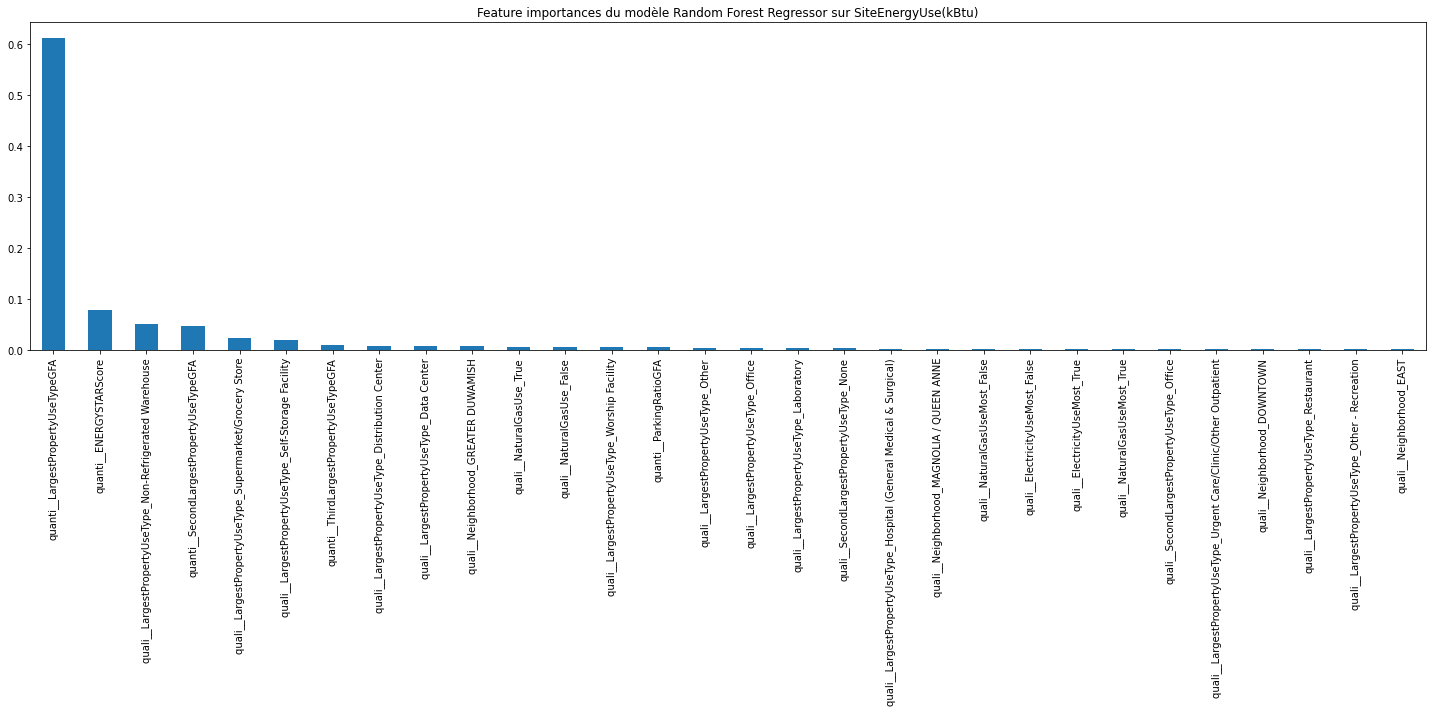

In [558]:
fig, ax = plt.subplots(figsize=(20,10))
df_features_importance.head(30).plot.bar(ax=ax)
ax.set_title("Feature importances du modèle Random Forest Regressor sur SiteEnergyUse(kBtu)")
fig.tight_layout()
plt.savefig('Feature importance SiteEnergyUse')

On constate certaines features ont plus d'importance dans la modélisation de *SiteEnergyUse(kBtu)*. En effet, nous avons notamment les variables: 
- *LargestPropertyUseTypeGFA*, 
- *EnergyStarScore*,
- *SecondLargestPropertyUseTypeGFA*, 
- *LargestPropertyUseType*,
- *ThirdLargestPropertyUseTypeGFA*,
- *Neighborhood*,
- *NaturalGasUse*,
- *ParkingRatioGFA*
- *SecondLargestPropertyUseType*,
- *ElectricityUseMost*,
- *NaturalGasUseMost*

qui ont un fort impact dans la modélisation.

Nous allons donc tenter de réentrainer un nouveau modèle de Random Forest Regressor avec seulement les variables jugées les plus importantes afin de voir si elles suffisent à obtenir des performances équivalentes ou meilleures. 

In [561]:
var_select = ['LargestPropertyUseTypeGFA','ENERGYSTARScore','SecondLargestPropertyUseTypeGFA',
              'LargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA','Neighborhood','ParkingRatioGFA',
              'NaturalGasUse','SecondLargestPropertyUseType','ElectricityUseMost','NaturalGasUseMost']
X_final = data.copy()[var_select]
y_final = data.copy()['SiteEnergyUse(kBtu)']

In [566]:
col_quant = X_final.select_dtypes(['int32','float64']).columns
col_qual = X_final.select_dtypes(['category','object','bool']).columns

preprocessor = ColumnTransformer(transformers =[
    ('quanti',std_scale,col_quant),
    ('quali',ohe,col_qual)
])

In [567]:
X_final[col_quant] = fc.knn_imputer(X_final[col_quant])

In [568]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state = 0)

In [569]:
mod_rf_f = Pipeline([('preprocessor', preprocessor),
                  ('model',TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth= None, 
                                                                                      n_estimators= 500), 
                                                      func=np.log, inverse_func=np.exp))])

In [570]:
mod_rf_f.fit(X_train_f,y_train_f)
print(mod_rf_f.score(X_train_f,y_train_f))
print(mod_rf_f.score(X_test_f,y_test_f))

0.8541300180305149
0.7242087317434629


In [574]:
rf_score_train = mod_rf_ESSk.score(X_train_ESS_k, y_train_ESS_k)
rf_score_test = mod_rf_ESSk.score(X_test_ESS_k, y_test_ESS_k)
rf_f_score_train = mod_rf_f.score(X_train_f,y_train_f)
rf_f_score_test = mod_rf_f.score(X_test_f,y_test_f)

In [575]:
df_comparaison_f = pd.DataFrame(data={'train_score':[rf_score_train,rf_f_score_train],
                                      'test_score': [rf_score_test,rf_f_score_test]},
                               index = ['Modèle initial', 'Modèle feature select'])

df_comparaison_f

,train_score,test_score
Modèle initial,0.843901,0.727552
Modèle feature select,0.854130,0.724209


Le modèle entraîné avec les 30 features les plus importantes retourne des performances similaires (mais très légèrement inférieures) au modèle entraîné avec toutes les features. On peut donc se demander si il n'est pas plus judicieux de n'utiliser que ces features pour la modélisation. Ainsi, cela permettrait d'avoir moins de variables à recolter. Un avis métier serait nécessaire pour confirmer ou infirmer cette hypothèse. 